# End-to-End ML project: Housing prices. 

Adapted from Hands-on ml book by Aurelien Geron

The task here is to predict median house values in Californian districts, given a number of features from these districts.

In [38]:
# Initial Setup that is required for the project
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ""


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from download_data import fetch_housing_data

# downloads the data and unzips it 
fetch_housing_data()

The data was downloaded to the following location: datasets/housing
Unzipping the file
Data downloading and unzipping complete!


In [3]:
from load_csv_using_panda import load_data

housing = load_data("datasets/housing/housing.csv")
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Understanding the data 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that there are 20640 instances in the data set. Also, we note that total_bedrooms column has only 20433 values, i.e. it has some null instances. One more observation here is that all the attributes are numerical except for ocean_proximity.

In [5]:
# exploring the data under ocean_proximity. It turns out that this is categorical attribute.
# To find out all the values of this category we can use values_counts()
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#We can also look at the details of other attributes using the describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


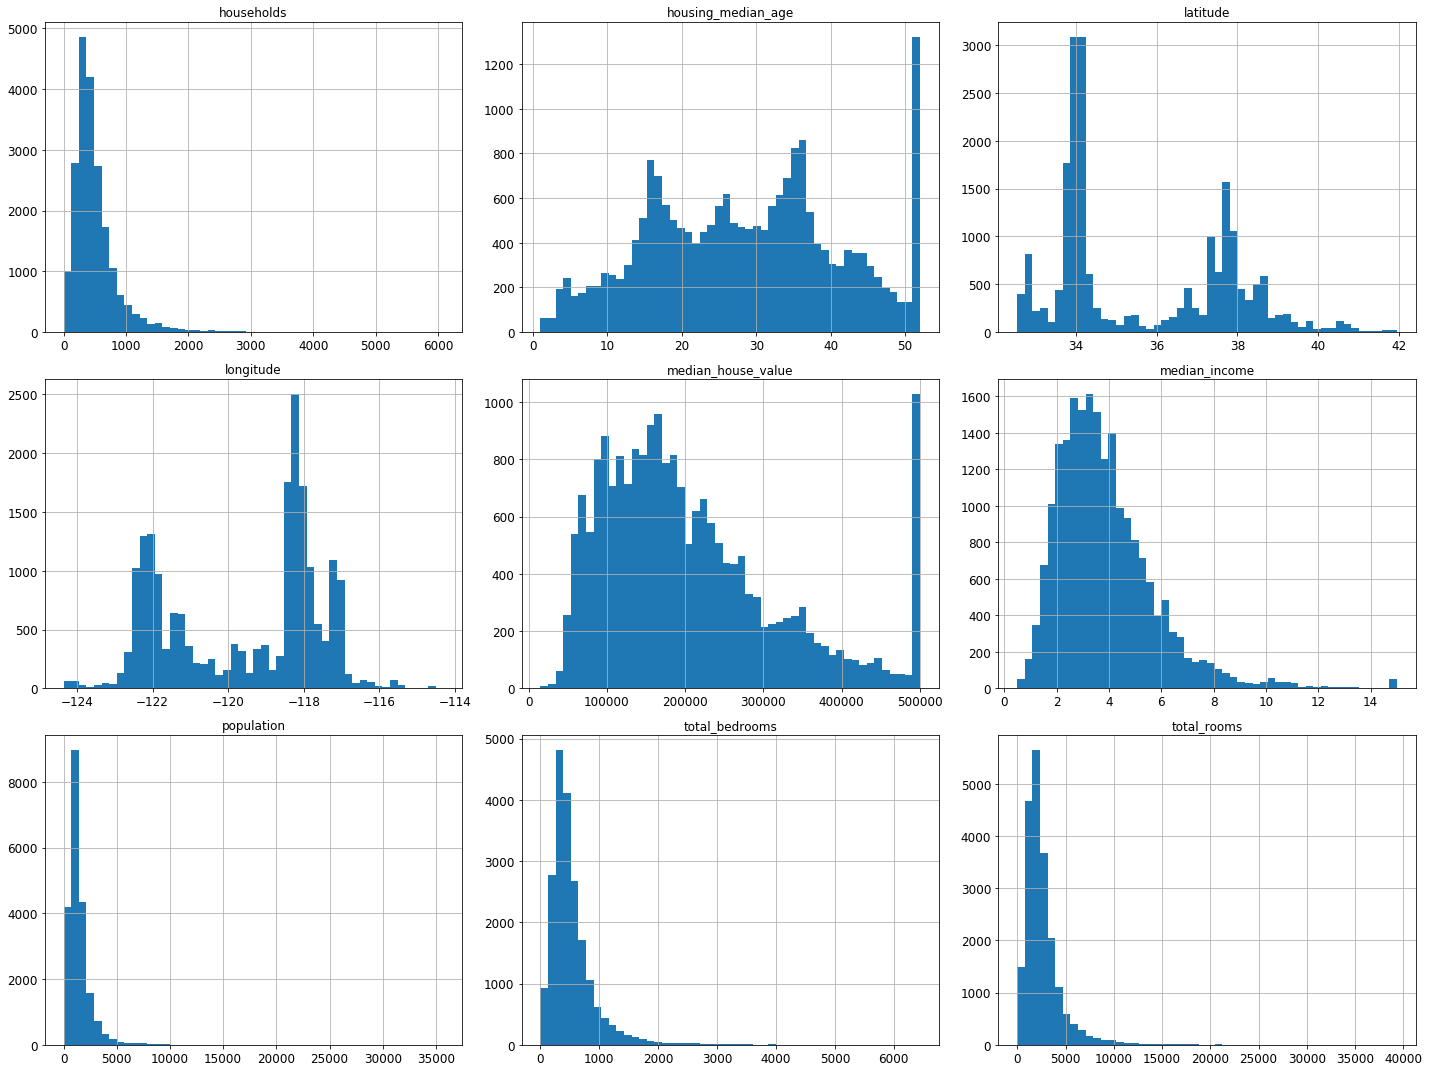

In [7]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

The data above indicates a few problems that we will take care in the further steps. For instance, many of the histograms above are tail heavy, some of the attributes have values that are capped such as median_income and housing_median_age. 

## Creating a test and train split

In [8]:
#Creation of test set using a simple numpy permutation()
from simple_seed_based_split import split_train_test

train_set, test_set = split_train_test(housing, 0.2, 42)
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape) 

Training set :  (16512, 10) 
 Test set : (4128, 10)


In [9]:
#Creating a test set using hashing function 
# This method will break if the dataset changes
# here we compute hash of every instance and then store the last byte of the hash
#

import hashlib

def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    tset_set_indexes = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[-tset_set_indexes], data.loc[tset_set_indexes]

#for the above code to run we would need to create a unique identifier for the dataset.
# solution 1: use the row index as unique identifier
housing_with_id = housing.reset_index() # adds and 'index' column
# issue with above solution? We always have to append an entry at the bottom of the set
# and we will to also ensure that no row ever gets deleted
housing_with_id.describe()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape)

Training set :  (16362, 11) 
 Test set : (4278, 11)


In [10]:
# To avoid the complicated situation above, we can create a custom unique identifier
# We will build one using the latitude and longitude

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape) 

Training set :  (16267, 12) 
 Test set : (4373, 12)


In [11]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [12]:
#Using sckitlearn to split test and train set
# This is particularaly useful if you have a separate data frame for labels. 
# Using the same seed value will generate same index samples across multiple data frames

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape)

Training set :  (16512, 10) 
 Test set : (4128, 10)


## How to ensure that the test set, is a good representation of an important feature?

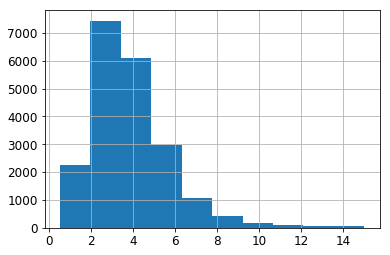

In [19]:
# According to the experts, median_income is an important feature.
# We have to ensure that the test set consists of all the categories of this feature
# If you see, this feature is a numerical feature --> we convert it to income category attribute
housing["median_income"].hist()

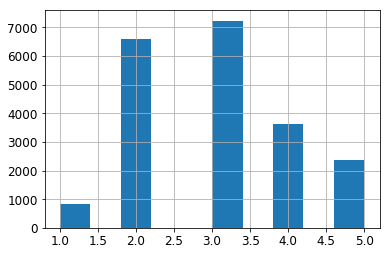

In [23]:
# we can observe more values that lie in the range 2-5. 
#The important thing is to have sufficient number of instances in each stratum
# or else the stratums importance maybe biased
# Also, we need to reduce the number of stratums that we create.

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#merging all the values greater than 5 to 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

In [69]:
#Now we are ready to do a stratified smapling based on the income category

from sklearn.cross_validation import StratifiedShuffleSplit

split = StratifiedShuffleSplit(housing["income_cat"], test_size=0.2)
train_indices, test_indices = next(iter(split))
strat_train_set = housing.loc[train_indices]
strat_test_set = housing.loc[test_indices]
print ("Training set : ",strat_train_set.shape,"\n","Test set :", strat_test_set.shape)

Training set :  (16512, 11) 
 Test set : (4128, 11)


In [70]:
#checking the distribution of the income_cat
housing["income_cat"].value_counts()/ len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [71]:
# Measuring the income_cat protions in test set with Stratified sampling vs test set with random sampling
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# consolidating the proportions of income_cat in both the data set
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

#calculating the error percentage in each proportion for both the test_sets
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [72]:
compare_props

#The below table shows that income_cat proportions in stratified sampline are closer to the overall dataset,
#as compared to random sampling.

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


### How to remove a feature coloumn from the pandas data frame?

In [73]:
strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
count,16512.000000,16512.000000,16512.000000,16512.000000,16345.000000,16512.000000,16512.00000,16512.000000,16512.000000,16512.000000
mean,-119.561124,35.622498,28.679688,2650.492490,540.418354,1437.229772,502.14650,3.867412,206265.822856,3.006541
std,2.004670,2.132440,12.605883,2191.808267,422.826127,1148.064139,384.19263,1.890130,115213.567368,1.054602
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.00000,0.499900,14999.000000,1.000000
25%,-121.792500,33.930000,18.000000,1452.000000,297.000000,796.000000,282.00000,2.561150,119200.000000,2.000000
50%,-118.490000,34.250000,29.000000,2142.000000,437.000000,1173.000000,411.00000,3.537500,178900.000000,3.000000
75%,-118.000000,37.710000,37.000000,3152.250000,648.000000,1732.000000,606.00000,4.742600,264200.000000,4.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.00000,15.000100,500001.000000,5.000000


In [74]:
strat_train_set.describe()
#restoring the data set, remvoing the income_cat feature

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16345.000000,16512.000000,16512.00000,16512.000000,16512.000000
mean,-119.561124,35.622498,28.679688,2650.492490,540.418354,1437.229772,502.14650,3.867412,206265.822856
std,2.004670,2.132440,12.605883,2191.808267,422.826127,1148.064139,384.19263,1.890130,115213.567368
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.00000,0.499900,14999.000000
25%,-121.792500,33.930000,18.000000,1452.000000,297.000000,796.000000,282.00000,2.561150,119200.000000
50%,-118.490000,34.250000,29.000000,2142.000000,437.000000,1173.000000,411.00000,3.537500,178900.000000
75%,-118.000000,37.710000,37.000000,3152.250000,648.000000,1732.000000,606.00000,4.742600,264200.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.00000,15.000100,500001.000000
